# <b>Importing Necessary Libraries

In [1]:
import pandas  as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#### Type in the cpaital here ####
capital = 50000

# <b> Creating Dataset

In [3]:
stocks = ['COL', 'CSL', 'FMG', 'FPH', 'JBH', 'RMD', 'SAR', 'TPM']

def starts_with_prefix(filename, stocks):
    return any(filename.upper().startswith(stocks) for stocks in stocks)

dfs = []
zip_path = 'archive.zip'
with zipfile.ZipFile(zip_path, 'r') as archive:
    for file_name in archive.namelist():
        if file_name.endswith('.csv') and starts_with_prefix(file_name, stocks):
            stock_symbol = os.path.splitext(os.path.basename(file_name))[0]
            with archive.open(file_name) as file:
                df = pd.read_csv(file)
                df['Stock'] = stock_symbol
                dfs.append(df)

if dfs:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.to_csv('merged.csv', index=False)
    print("Concatenation complete. Saved as 'merged.csv'.")
else:
    print("No matching CSV files found.")


Concatenation complete. Saved as 'merged.csv'.


In [4]:
concatenated_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,2018-11-21,12.49,13.37,12.300,12.75,12.392522,8752527.0,COL
1,2018-11-22,12.85,12.91,12.210,12.75,12.392522,5673815.0,COL
2,2018-11-23,12.75,12.85,12.620,12.84,12.479999,5474121.0,COL
3,2018-11-26,12.84,13.30,12.720,13.11,12.742429,5085525.0,COL
4,2018-11-27,13.05,13.13,12.750,12.89,12.528598,6747945.0,COL
...,...,...,...,...,...,...,...,...
34619,2020-03-26,6.82,7.15,6.770,6.94,6.911479,1490585.0,TPM
34620,2020-03-27,6.96,7.07,6.635,6.72,6.692384,2939934.0,TPM
34621,2020-03-30,6.57,7.10,6.570,7.10,7.070822,1115726.0,TPM
34622,2020-03-31,7.00,7.22,6.750,6.89,6.861685,1659093.0,TPM


# <b>Handling Missing Values

In [5]:
numeric_df= concatenated_df.select_dtypes(include=[np.number])

<Axes: >

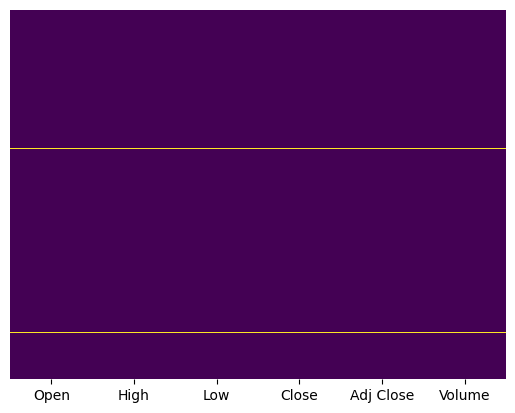

In [6]:
sns.heatmap(numeric_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

In [7]:
def impute_with_window(ds, column, window_size=5, method='mean'):
    def impute_value(s):
        for i in range(len(s)):
            if pd.isnull(s[i]):
                window_start = max(0, i - window_size)
                window_end = min(len(s), i + window_size + 1)
                window_values = s[window_start:window_end]
                if method == 'mean':
                    s[i] = window_values.mean()
                elif method == 'median':
                    s[i] = window_values.median()
        return s
    
    ds[column] = impute_value(ds[column].copy())
    return ds

ds = pd.read_csv('merged.csv')



columns_to_impute = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

for column in columns_to_impute:
    ds = impute_with_window(ds, column, window_size=5, method='mean') 

ds['Volume'] = ds['Volume'].round().astype(int)
ds.to_csv('imputed.csv')

<Axes: >

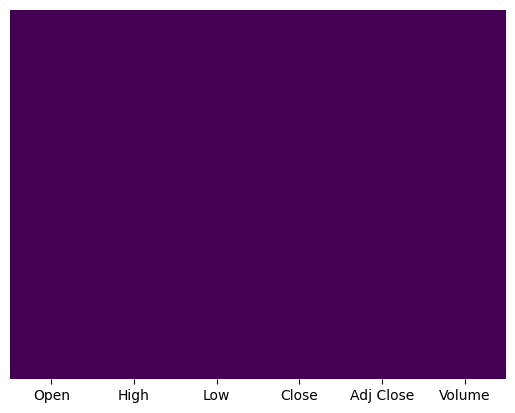

In [8]:
num_new = ds.select_dtypes(include=[np.number])
sns.heatmap(num_new.isnull(), cbar=False, cmap='viridis', yticklabels=False)

# <b>Pivoting Dataframe 

In [9]:
ds['Date'] = pd.to_datetime(ds['Date'])
adj_values = ds.pivot(index='Date', columns='Stock', values='Adj Close')
adj_values = adj_values.sort_index()

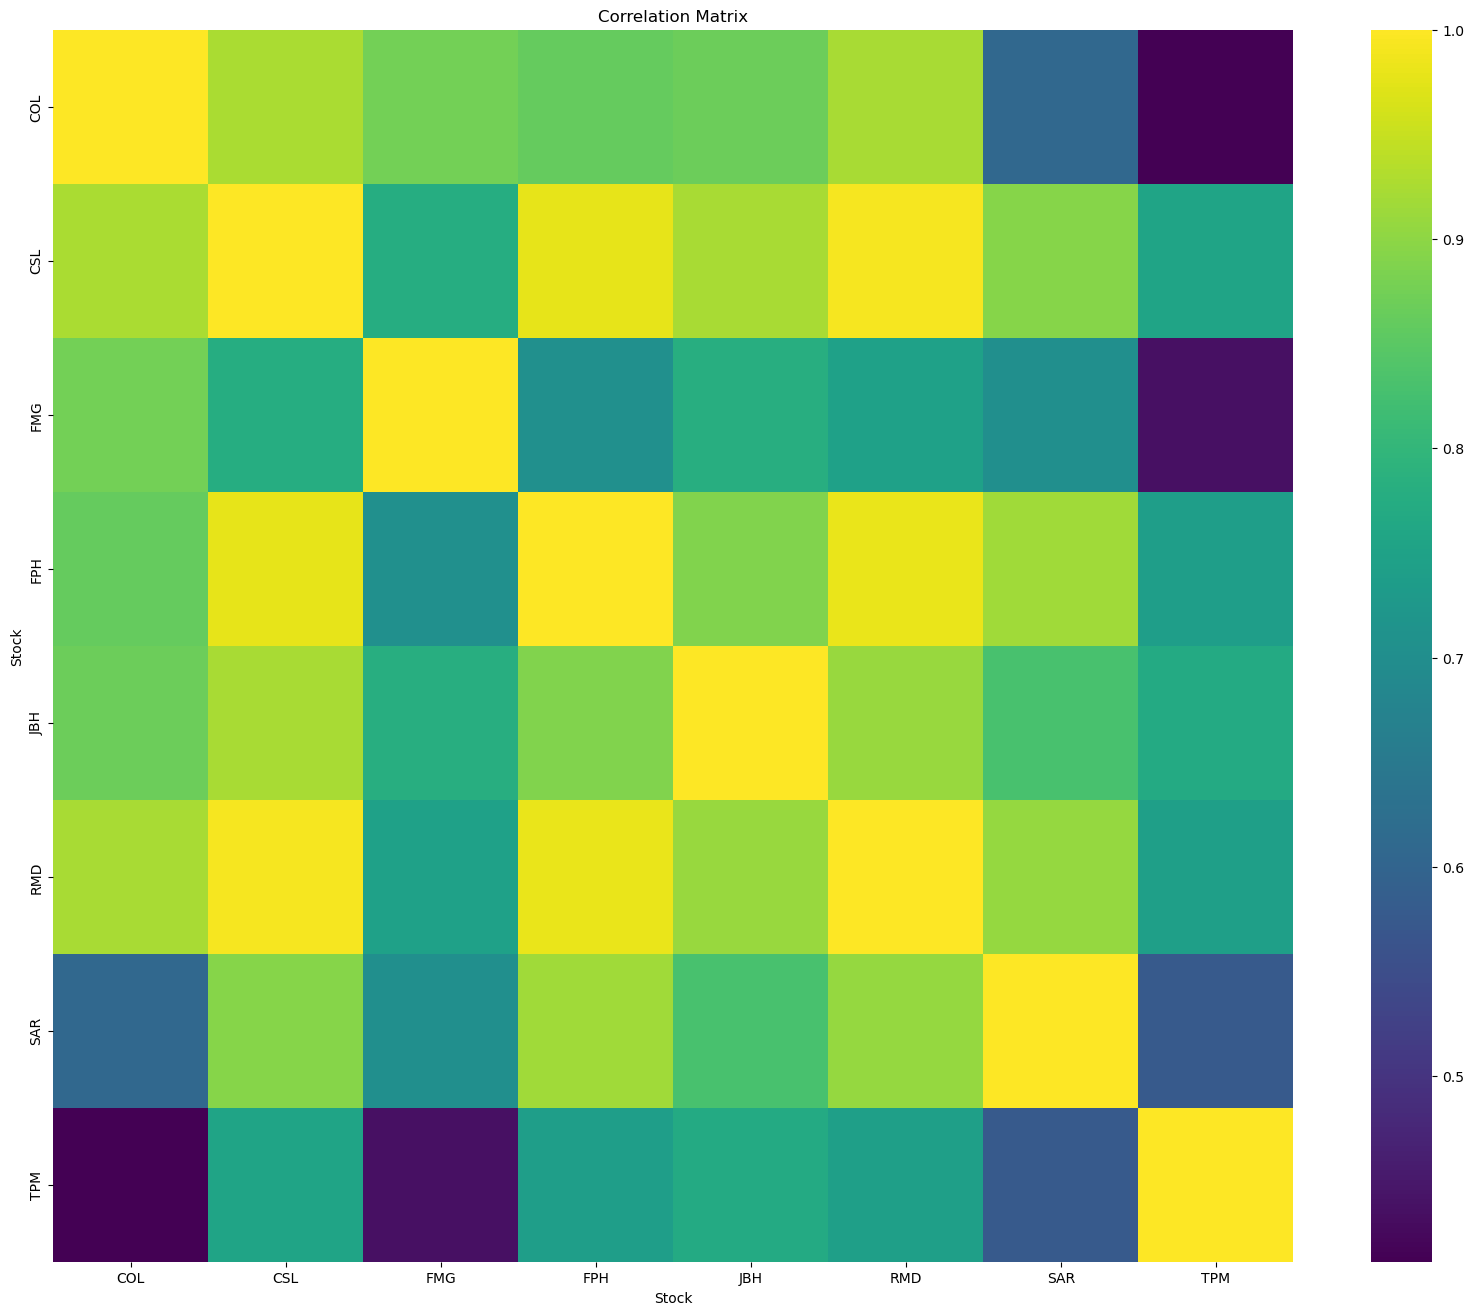

In [10]:
plt.figure(figsize=(20,16))
sns.heatmap(adj_values.corr(), annot=False, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

# <b>Calculating Log Normal Returns

In [11]:
log_returns = np.log(adj_values / adj_values.shift(1)).dropna()
log_returns

Stock,COL,CSL,FMG,FPH,JBH,RMD,SAR,TPM
Date,,,,,,,,
2018-11-22,0.000000,0.033228,0.010050,0.011551,0.032819,0.002849,-0.015209,0.001332
2018-11-23,0.007034,-0.013565,0.002497,0.007356,0.006436,0.008499,-0.011560,0.005312
2018-11-26,0.020810,-0.014475,-0.040718,0.017757,0.008942,0.009126,0.011560,0.001323
2018-11-27,-0.016923,-0.001113,0.000000,0.004789,-0.002122,0.006964,-0.019344,0.014446
2018-11-28,-0.014850,0.001559,0.023107,-0.024991,-0.016706,0.009669,-0.072907,-0.002611
...,...,...,...,...,...,...,...,...
2020-03-26,-0.006024,0.060153,0.028932,0.005831,0.094923,0.023948,-0.030600,-0.002878
2020-03-27,-0.050816,-0.078752,-0.091515,-0.009126,-0.061859,-0.011016,-0.017094,-0.032213
2020-03-30,0.066999,0.113539,0.050772,0.103048,0.100201,0.066420,0.082692,0.055007


# <b>Covariance Matrix

In [12]:
cov_matrix = log_returns.cov()*252
cov_matrix

Stock,COL,CSL,FMG,FPH,JBH,RMD,SAR,TPM
Stock,,,,,,,,
COL,0.085885,0.044347,0.045439,0.024311,0.035309,0.028571,0.024519,0.043369
CSL,0.044347,0.104913,0.055403,0.033007,0.057273,0.038450,0.015982,0.049363
FMG,0.045439,0.055403,0.205670,0.009820,0.047888,0.035704,0.011999,0.049233
FPH,0.024311,0.033007,0.009820,0.094237,0.014459,0.034465,0.010829,0.019642
JBH,0.035309,0.057273,0.047888,0.014459,0.140864,0.032603,0.012552,0.047414
RMD,0.028571,0.038450,0.035704,0.034465,0.032603,0.121158,0.022342,0.025990
SAR,0.024519,0.015982,0.011999,0.010829,0.012552,0.022342,0.309785,0.041902
TPM,0.043369,0.049363,0.049233,0.019642,0.047414,0.025990,0.041902,0.161333


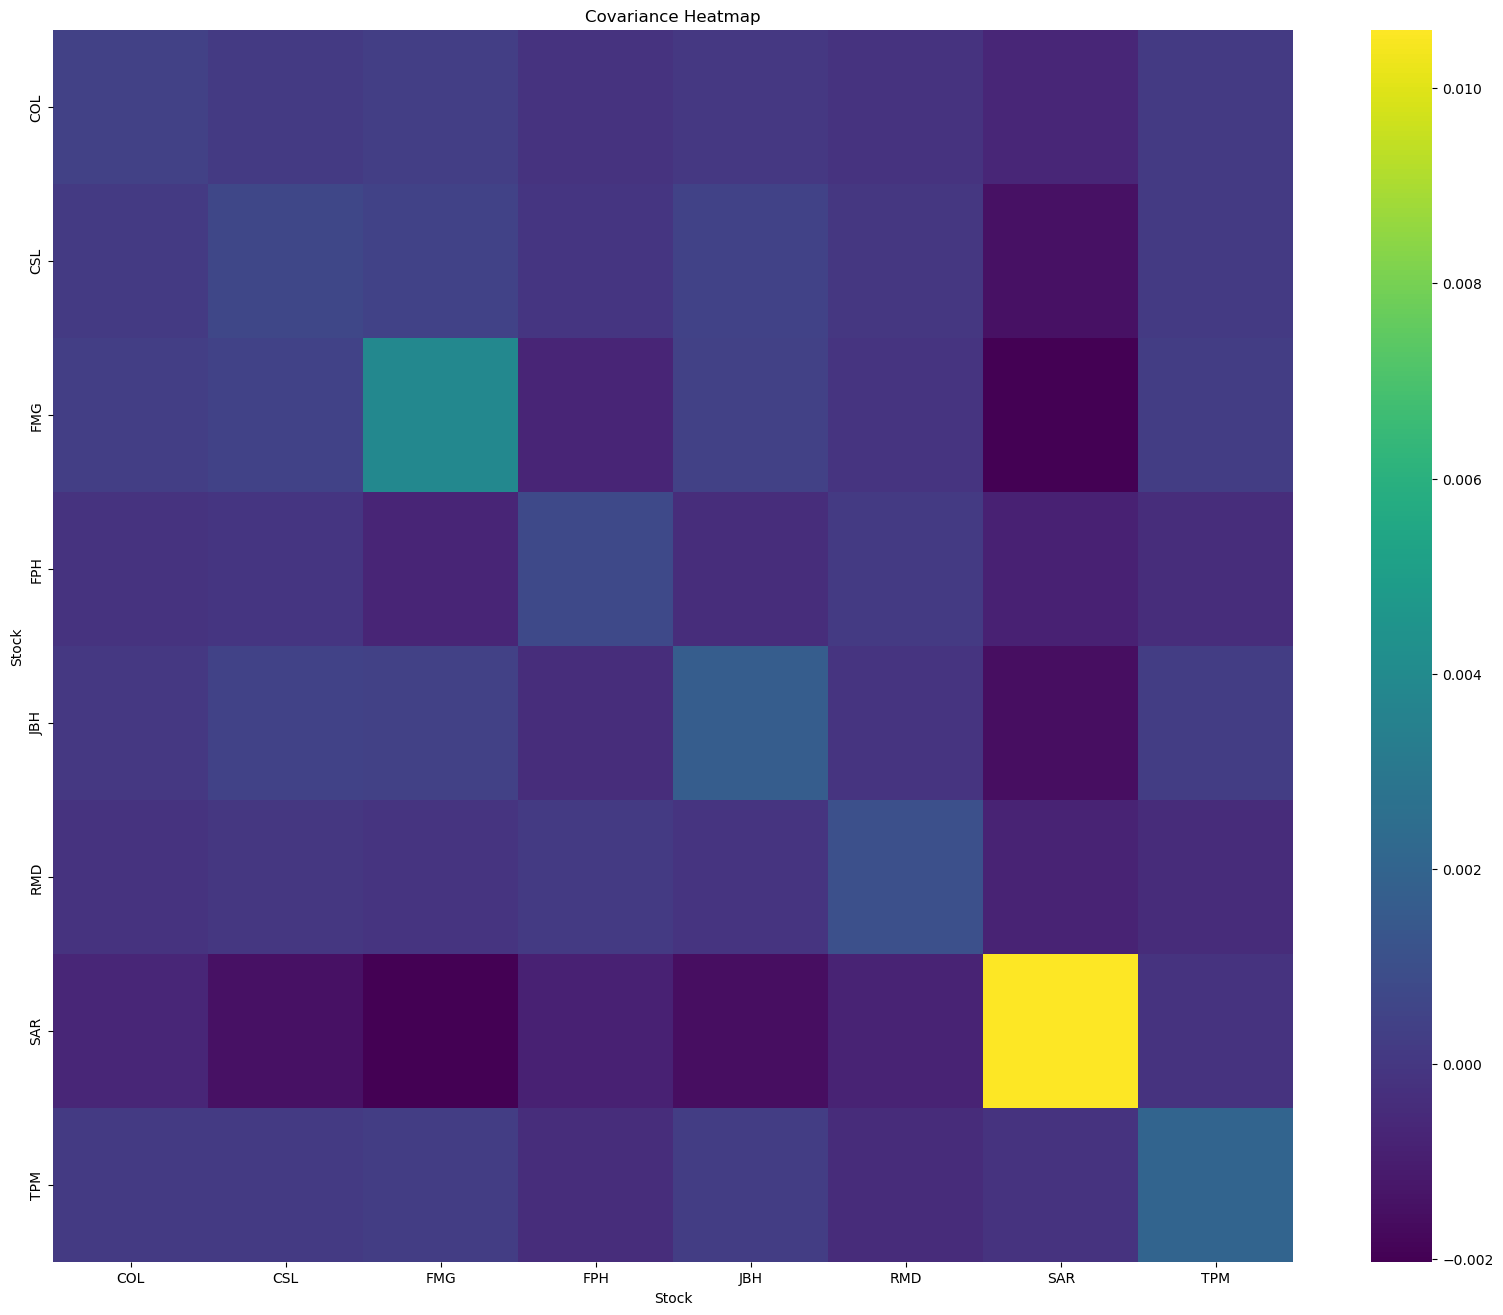

In [13]:
plt.figure(figsize=(20,16))
sns.heatmap(cov_matrix.cov(), annot=False, cmap='viridis')
plt.title('Covariance Heatmap')
plt.show()

# <b>Defining Functions

### Standard Deviation

In [14]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

### Expected Return

In [15]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

### Sharpe Ratio

In [16]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return (weights, log_returns) - risk_free_rate)/ standard_deviation (weights, cov_matrix)

# <b>Calculating Risk Free Rate

In [17]:
from fredapi import Fred

fred= Fred(api_key='f00022e0e814b865d9e051622ba04467')
ten_year_treasury_rate= fred.get_series_latest_release('GS10')/100

risk_free_rate= ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.0431


# <b>Defining Negative Sharpe Ratio

In [18]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# <b>Constraints & Bounds

In [19]:
constraints= {'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}
bounds= [(0, 0.5) for _ in range(len(dfs))]

In [20]:
innitial_weights = np.array([1/len(dfs)]*len(dfs))
innitial_weights.sum()
innitial_weights


array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

# <b>Optimize Weights to Maximize Sharpe Ratio

In [21]:
from scipy.optimize import minimize
optimized_results= minimize(neg_sharpe_ratio, innitial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [22]:
optimal_weights = optimized_results.x
optimal_weights

array([0.        , 0.00290138, 0.36419884, 0.5       , 0.02095318,
       0.05759861, 0.054348  , 0.        ])

# <b>Output

In [23]:
latest_prices = adj_values.iloc[-1]
investments = (optimal_weights * capital)
counts = np.array(investments // latest_prices)
portfolio_return = expected_return(optimal_weights, log_returns)
portfolio_risk = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

output_df = pd.DataFrame({
    'Stock': stocks,
    'Counts': counts.astype(int),
    'Investments': investments.round(2),
    'Latest Price': latest_prices.round(2).values
})

print(output_df)
print(f"\nCapital: {capital}")
print(f"Return: {portfolio_return:.4f}")
print(f"Risk: {portfolio_risk:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f} ")

  Stock  Counts  Investments  Latest Price
0   COL       0         0.00         15.83
1   CSL       0       145.07        307.00
2   FMG    1759     18209.94         10.35
3   FPH     839     25000.00         29.78
4   JBH      33      1047.66         30.99
5   RMD     121      2879.93         23.64
6   SAR     722      2717.40          3.76
7   TPM       0         0.00          7.31

Capital: 50000
Return: 0.6977
Risk: 0.2487
Sharpe Ratio: 2.6319 
